## 20201222 Better binders flow

Overview
- flow cytometry on "better" binders derived from IRAY NNK selection
- induction curves of prey half
- 3 replicates on three separate days:
    - 20201222
    - 20201223
    - 20201224

Conditions:
- 30C, TB media, deepwell plates
- Cumate: 100uM (induces papB)
- OC6AHL: 0-1uM (induces RiPP half of intein)

Strains:

|Strain name| Description|
|---|---|
sDAA991|VID variant + w/ RBD intein + pcym-pap
sDAA992|VVE variant + w/ RBD intein + pcym-pap
sDAA993|LVE variant + w/ RBD intein + pcym-pap
sDAA994|IVE variant + w/ RBD intein + pcym-pap
sDAA995|VIE variant + w/ RBD intein + pcym-pap
sDAA996|LIE variant + w/ RBD intein + pcym-pap
sDAA997|IIE variant + w/ RBD intein + pcym-pap
sDAA998|VID variant + mdm2 intein + pcym-pap
sDAA999|VVE variant + mdm2 intein + pcym-pap
sDAA1000|LVE variant + mdm2 intein + pcym-pap
sDAA1001|IVE variant + mdm2 intein + pcym-pap
sDAA1002|VIE variant + mdm2 intein + pcym-pap
sDAA1003|LIE variant + mdm2 intein + pcym-pap
sDAA1004|IIE variant + mdm2 intein + pcym-pap
sDAA867|RBD pap2c hit w/ mdm2 intein + pcym-pap
sDAA869|RBD pap2c hit w/ RBD intein + pcym-pap

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import sys
import cytoflow as flow
import string
import pandas as pd
import seaborn as sns
from scipy import stats
import re
import matplotlib.colors as colors

sys.path.append('../modules')
import cf_imports
import cf_helpers

In [2]:
import matplotlib
%matplotlib inline

In [3]:
matplotlib.rc('figure', dpi = 150)
sns.set_style('ticks')

In [4]:
# Import reloads for when modules are being changed
import importlib
importlib.reload(cf_imports)
importlib.reload(cf_helpers)

<module 'cf_helpers' from '../modules\\cf_helpers.py'>

## Data Import

In [5]:
# Provide full path to flow cytometry .fcs file directory and pass to fixer
exp_dirs = [
    r'C:\Users\Dan\Dropbox (MIT)\Flow Data\20201222_amk_better_binders_rep1\20201222_amk_better_binders_rep1_plate1',
    r'C:\Users\Dan\Dropbox (MIT)\Flow Data\20201222_amk_better_binders_rep1\20201222_amk_better_binders_rep1_plate2',
    r'C:\Users\Dan\Dropbox (MIT)\Flow Data\20201223_amk_better_binders_rep2\20201223_amk_better_binders_rep2_plate1',
    r'C:\Users\Dan\Dropbox (MIT)\Flow Data\20201223_amk_better_binders_rep2\20201223_amk_better_binders_rep2_plate2',
    r'C:\Users\Dan\Dropbox (MIT)\Flow Data\20201224_amk_better_binders_rep3\20201224_amk_better_binders_rep3_plate1',
    r'C:\Users\Dan\Dropbox (MIT)\Flow Data\20201224_amk_better_binders_rep3\20201224_amk_better_binders_rep3_plate2'
]
conds_dir = None

# Loop through all and add to one dataframe
i = 0
for exp_dir in exp_dirs:
    fcs_dir = cf_imports.dir_fix(exp_dir)
    exp = cf_imports.exp_from_dirs(fcs_dir, conds_dir, event_num = 5000) #subset 5000 events
    
    if i == 0:
        exp_df = exp.data
    else:
        exp_df = exp_df.append(exp.data)
    
    i = i+1

exp_df = exp_df[exp_df['FITC-A'] >0]
exp_df = exp_df[exp_df['empty'] == False]

C:\Users\Dan\Anaconda3\envs\cf_dash\lib\site-packages\cytoflow\operations\import_op.py:381: CytoflowWarning: Only 1567 events in tube C:/Users/Dan/Dropbox (MIT)/Flow Data/20201222_amk_better_binders_rep1/20201222_amk_better_binders_rep1_plate1\Specimen_001_A9_A09.fcs
C:\Users\Dan\Anaconda3\envs\cf_dash\lib\site-packages\cytoflow\operations\import_op.py:381: CytoflowWarning: Only 1659 events in tube C:/Users/Dan/Dropbox (MIT)/Flow Data/20201222_amk_better_binders_rep1/20201222_amk_better_binders_rep1_plate1\Specimen_001_B9_B09.fcs
C:\Users\Dan\Anaconda3\envs\cf_dash\lib\site-packages\cytoflow\operations\import_op.py:381: CytoflowWarning: Only 1265 events in tube C:/Users/Dan/Dropbox (MIT)/Flow Data/20201222_amk_better_binders_rep1/20201222_amk_better_binders_rep1_plate1\Specimen_001_C9_C09.fcs
C:\Users\Dan\Anaconda3\envs\cf_dash\lib\site-packages\cytoflow\operations\import_op.py:381: CytoflowWarning: Only 1288 events in tube C:/Users/Dan/Dropbox (MIT)/Flow Data/20201222_amk_better_binde

In [44]:
exp_df['bait'] = exp_df['bait'].astype('category')
for cat in ['name', 'bait', 'strain']:
    exp_df[cat] = exp_df[cat].cat.remove_unused_categories()

In [5]:
# Pickle the dataframe so we don't have to import everything every time
#exp_df.to_pickle('20201222_better_binders_all_reps.bz2')
exp_df = pd.read_pickle('20201222_better_binders_all_reps.bz2')

## Histograms to check for bimodality

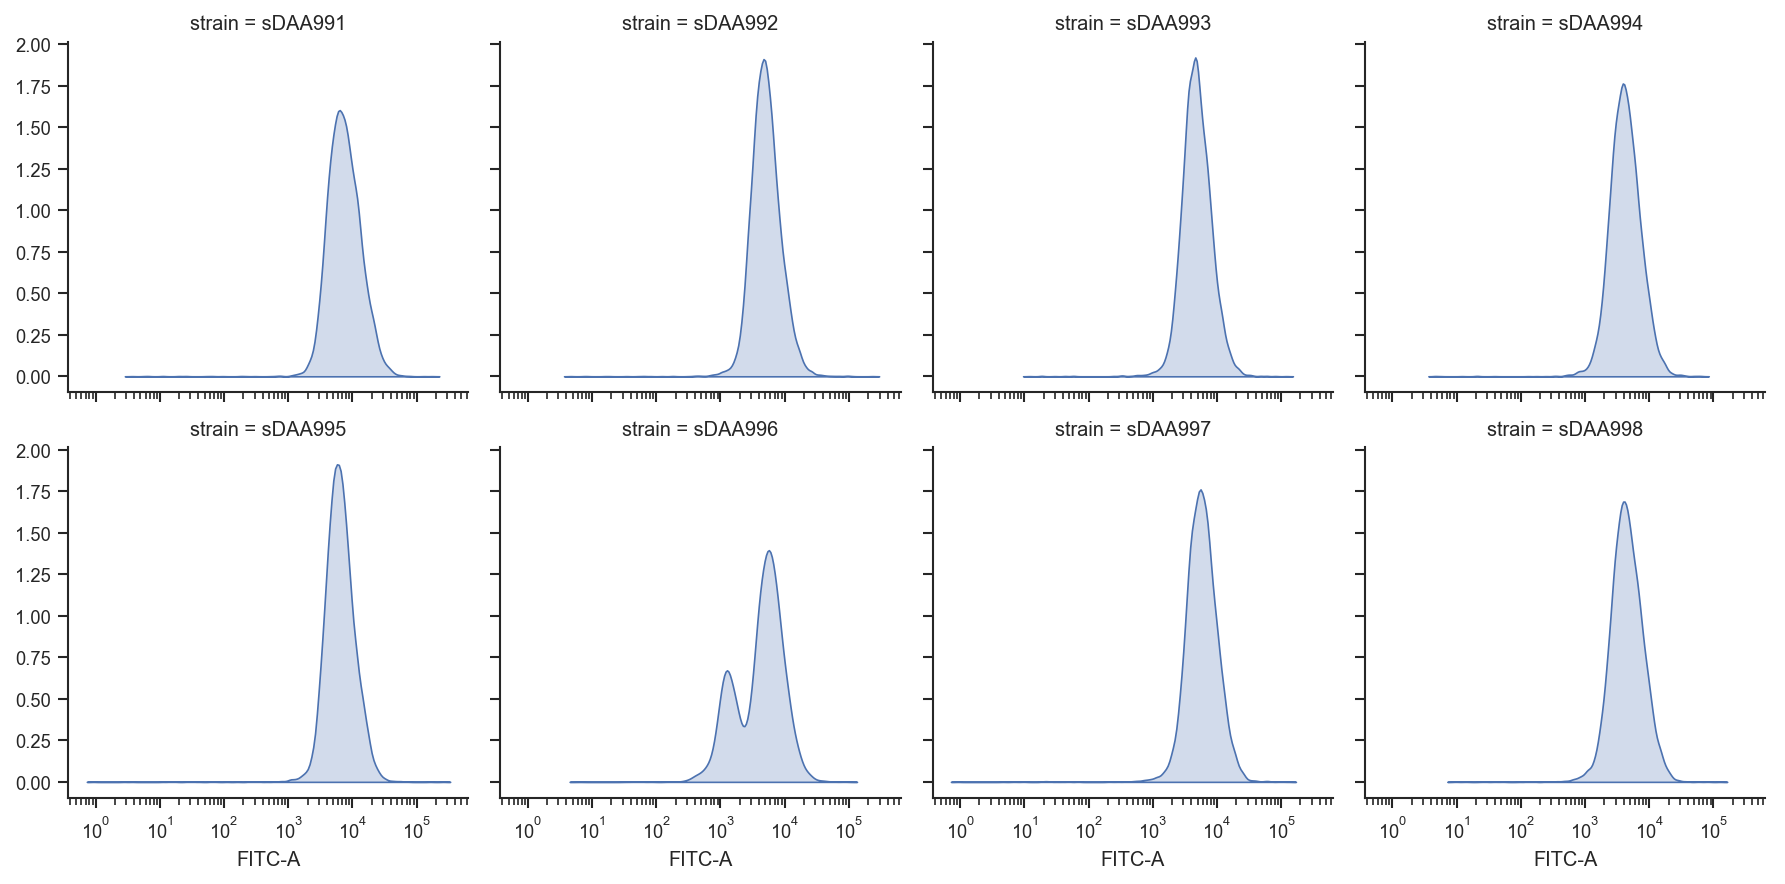

In [6]:
sub_df = exp_df[(exp_df['bait'] == 'rbd') &(exp_df['AHL'] == 1)]

g = sns.FacetGrid(sub_df,col = 'strain', col_order = np.sort(sub_df['strain'].unique()), col_wrap = 4)
g.map(sns.kdeplot, 'FITC-A', log_scale = True, fill = True)

Definitely some bimodaility in the sDAA996 strain (LIE variant). Would probably want to remove these data. Or if we want to get info for it, streak out the glycerol stock and pick single colonies

## Extract induction curves

In [7]:
exp_df.head()

,AHL,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,PE-A,PE-H,PE-Texas Red-A,...,SSC-H,SSC-W,Time,bait,col,empty,name,rep,row,strain
0,0.0,3136.890137,2978.0,69032.656250,1381.710083,1483.0,61059.843750,260.480011,225.0,1207.680054,...,5382.0,66837.218750,343.000000,rbd,1,False,VID,1,A,sDAA991
1,0.0,4342.169922,3494.0,81444.890625,2897.719971,2575.0,73749.515625,393.679993,334.0,2903.020020,...,8667.0,88831.328125,309.200012,rbd,1,False,VID,1,A,sDAA991
2,0.0,16318.709961,15862.0,67422.968750,9351.230469,8703.0,70417.351562,642.320007,691.0,5658.780273,...,12699.0,67278.992188,290.500000,rbd,1,False,VID,1,A,sDAA991
3,0.0,3182.459961,3142.0,66379.921875,1516.010010,1995.0,49801.121094,235.320007,285.0,1983.940063,...,7670.0,65907.000000,507.399994,rbd,1,False,VID,1,A,sDAA991
4,0.0,808.169983,763.0,69415.765625,2424.510010,2791.0,56930.378906,59.200001,43.0,373.700012,...,6799.0,66981.476562,341.100006,rbd,1,False,VID,1,A,sDAA991


In [8]:
exp_df_median = exp_df.groupby(['strain', 'name', 'bait', 'AHL', 'rep'])['FITC-A'].agg('median').reset_index()
exp_df_median.head()

,strain,name,bait,AHL,rep,FITC-A
0,sDAA991,VID,mdm2,0.000000,1,36.270000
1,sDAA991,VID,mdm2,0.000000,2,34.410000
2,sDAA991,VID,mdm2,0.000000,3,33.480000
3,sDAA991,VID,mdm2,0.000244,1,39.060001
4,sDAA991,VID,mdm2,0.000244,2,36.270000


### Plot induction curves

In [9]:
order = ['VID', 'VVE', 'LVE', 'IVE', 'VIE', 'LIE', 'IIE', 'parent']

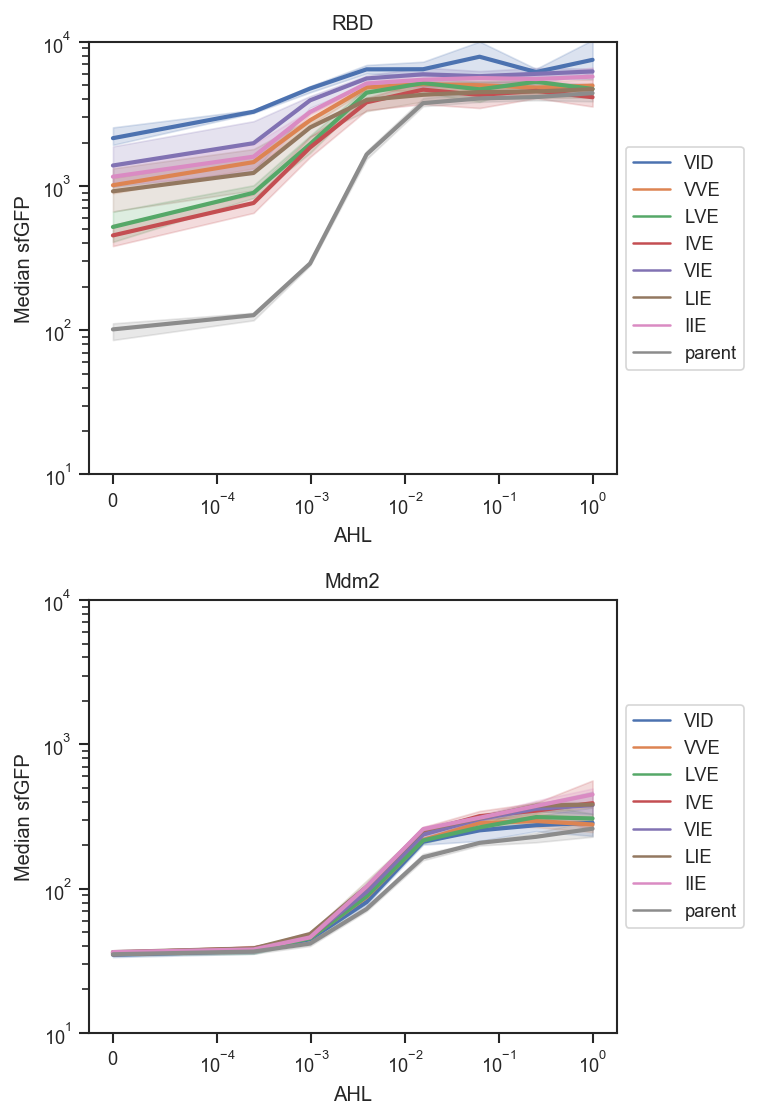

In [10]:
fig, axs = plt.subplots(figsize = (5,8),nrows = 2)
plt.tight_layout(pad = 4)

rbd_df = exp_df_median[exp_df_median['bait'] == 'rbd']
g1 = sns.lineplot(x = 'AHL', y = 'FITC-A', hue = 'name', data = rbd_df, ax = axs[0], linewidth = 2, hue_order = order)
g1.set_title('RBD')

mdm2_df = exp_df_median[exp_df_median['bait'] == 'mdm2']
g2 = sns.lineplot(x = 'AHL', y = 'FITC-A', hue = 'name', data = mdm2_df, ax = axs[1], linewidth = 2, hue_order = order)
g2.set_title('Mdm2')

for ax in axs:
    ax.set_ylabel('Median sfGFP')
    ax.set_ylim(1e1,1e4)
    ax.set_xscale('symlog', linthreshx = 0.0001)
    ax.set_yscale('log')

g1.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
g2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

plt.show()

## Plot without LIE (the weird bimodal variant)

In [11]:
order = ['VID', 'VVE', 'LVE', 'IVE', 'VIE', 'IIE', 'parent']

In [87]:
def ind_plot(df, ax):
    
    line_width = 1
    order = ['parent', 'IVE', 'LVE', 'VVE', 'IIE', 'VIE', 'VID']
    
    g = sns.lineplot(
        x = 'AHL', y = 'FITC-A', hue = 'name', data = df, ax = ax, linewidth = line_width, hue_order = order,
        ci = 'sd', err_style = 'bars', markers = True, marker = 'o', mec = None, ms = 4*line_width,
        err_kws = {
            'elinewidth': line_width,
            'capsize': 2*line_width, 
            'capthick': line_width}
    )
    # Formatting    
    ax.set_ylabel('Fluorescence (AU)')
    ax.set_xlabel('3OC6-AHL (nM)')
    ax.set_ylim(1e1,1e4)
    ax.set_xscale('symlog', linthreshx = 1e-4, subsx = [2, 3, 4, 5, 6, 7, 8, 9])
    ax.set_yscale('log')
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon = False)
        
    return ax

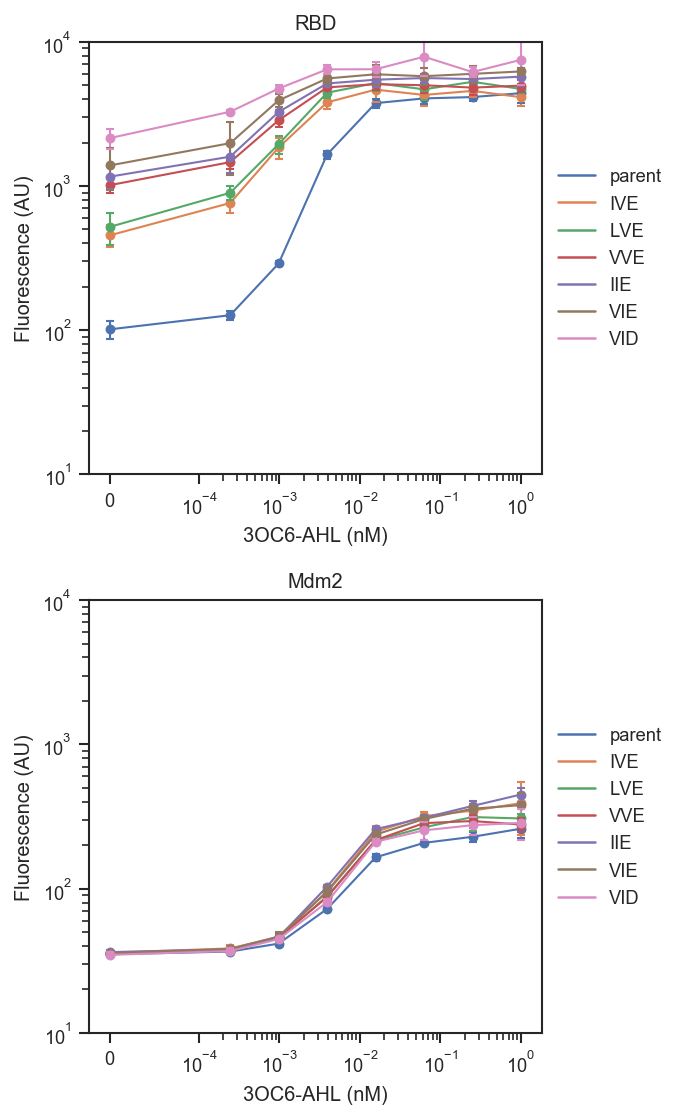

In [88]:
fig, axs = plt.subplots(figsize = (4.5,8),nrows = 2)
plt.tight_layout(pad = 4)

# Make RBD plot
rbd_df = exp_df_median[exp_df_median['bait'] == 'rbd']
axs[0] = ind_plot(rbd_df, axs[0])
axs[0].set_title('RBD')

# Make Mdm2 plot
mdm2_df = exp_df_median[exp_df_median['bait'] == 'mdm2']
axs[1] = ind_plot(mdm2_df, axs[1])
axs[1].set_title('Mdm2')


plt.show()

Mutants are definitely better than the parental (rbd). No clear non-specific binding (mdm2)

## Apparent rank order of binding strength (WITHOUT LIE)
* Gotten by looking at lowest induction value of AHL

In [14]:
exp_df_median.head()

,strain,name,bait,AHL,rep,FITC-A
0,sDAA991,VID,mdm2,0.000000,1,36.270000
1,sDAA991,VID,mdm2,0.000000,2,34.410000
2,sDAA991,VID,mdm2,0.000000,3,33.480000
3,sDAA991,VID,mdm2,0.000244,1,39.060001
4,sDAA991,VID,mdm2,0.000244,2,36.270000


In [15]:
sub_df = exp_df_median[(exp_df_median['AHL'] == 0) & (exp_df_median['bait'] == 'rbd')]
order = sub_df.groupby('name').agg('median').sort_values('FITC-A').reset_index()['name'].values

In [22]:
order = ['parent', 'IVE', 'LVE', 'VVE', 'IIE', 'VIE', 'VID']
order

['parent', 'IVE', 'LVE', 'VVE', 'IIE', 'VIE', 'VID']

Text(0, 0.5, 'Median FITC-A')

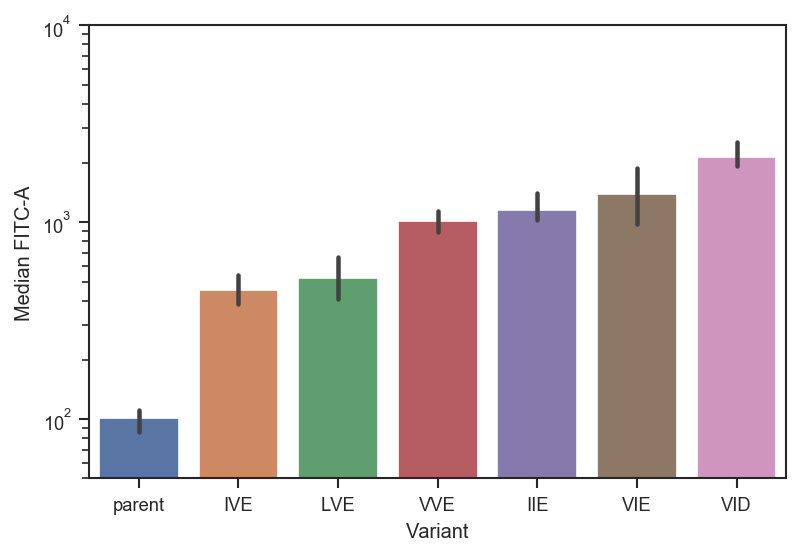

In [25]:
fig, ax = plt.subplots()

sns.barplot(data = sub_df, x = 'name', y = 'FITC-A', order = order)

ax.set_yscale('log')
ax.set_ylim(5e1,1e4)
ax.set_xlabel('Variant')
ax.set_ylabel('Median FITC-A')

## Manuscript plots

In [89]:
import matplotlib as mpl

# Set matplotlib parameters
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.transparent'] = True

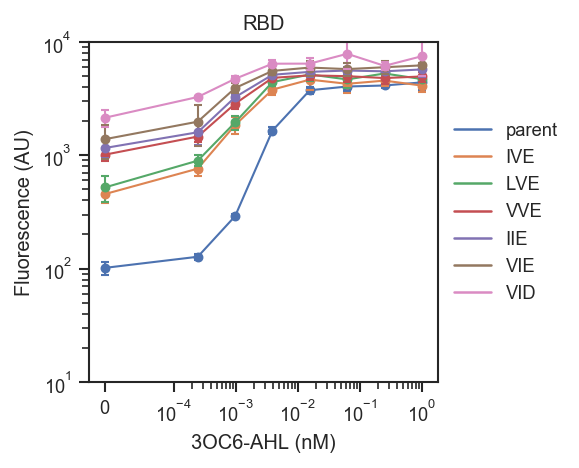

In [93]:
fig, ax = plt.subplots(figsize = (3,3))

# Make RBD plot
rbd_df = exp_df_median[exp_df_median['bait'] == 'rbd']
ax = ind_plot(rbd_df, ax)
ax.set_title('RBD')

plt.savefig(r"C:\Users\Dan\Dropbox (MIT)\COVID manuscript\figures\python_figures" + "/" + 'IRAY_mutations_RBD.pdf' )
plt.show()

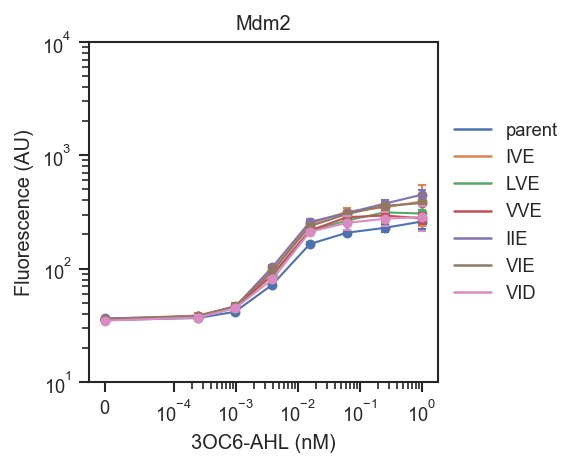

In [94]:
# Make Mdm2 plot
fig, ax = plt.subplots(figsize = (3,3))

# Make RBD plot
mdm2_df = exp_df_median[exp_df_median['bait'] == 'mdm2']
ax = ind_plot(mdm2_df, ax)
ax.set_title('Mdm2')

plt.savefig(r"C:\Users\Dan\Dropbox (MIT)\COVID manuscript\figures\python_figures" + "/" + 'IRAY_mutations_mdm2.pdf' )
plt.show()

All variants at minimum AHL

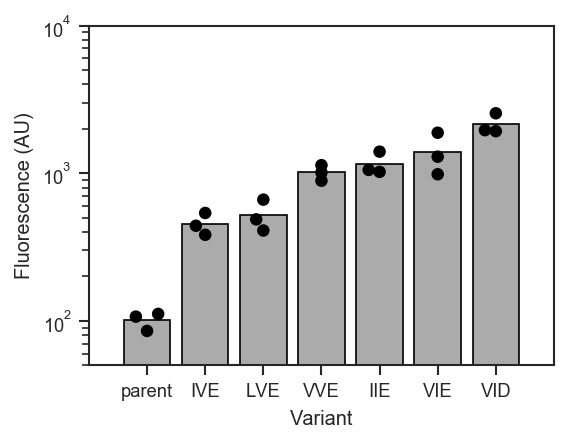

In [96]:
sub_df = exp_df_median[(exp_df_median['AHL'] == 0) & (exp_df_median['bait'] == 'rbd')]
order = ['parent', 'IVE', 'LVE', 'VVE', 'IIE', 'VIE', 'VID']

fig, ax = plt.subplots(figsize = (4,3))

# Plot bars at the mean values
sns.barplot(
    data = sub_df, x = 'name', y = 'FITC-A', order = order, ax = ax, color = '#ababab',
    ci = None, edgecolor = 'black'
)

# Plot all points
sns.swarmplot(
    data = sub_df, x = 'name', y = 'FITC-A', order = order, ax = ax, color = 'black',
    edgecolor = 'black', linewidth = 1, size = 5
)

ax.set_yscale('log')
ax.set_ylim(5e1,1e4)
ax.set_xlim(-1, 7)
ax.set_xlabel('Variant')
ax.set_ylabel('Fluorescence (AU)')

plt.savefig(r"C:\Users\Dan\Dropbox (MIT)\COVID manuscript\figures\python_figures" + "/" + 'IRAY_mutations_minAHL.pdf')
plt.show()